# Stacking



In [213]:
from __future__ import print_function 
from __future__ import division


# Load in our libraries
import pandas as pd
import numpy as np
import re
import sklearn
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import itertools
from time import time
from pathlib import Path


import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

import warnings
warnings.filterwarnings('ignore')

from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, 
                              GradientBoostingClassifier, ExtraTreesClassifier)
from sklearn.svm import SVC
#from sklearn.cross_validation import KFold
from sklearn.model_selection import KFold, cross_val_score
from mlxtend.classifier import StackingClassifier

from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import r2_score, mean_absolute_error, accuracy_score, make_scorer, fbeta_score, confusion_matrix
from sklearn.metrics import f1_score, recall_score, precision_score
from sklearn.model_selection import train_test_split

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.naive_bayes import GaussianNB 
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline

SEED=42
FBETA=.25
goalsToReach = {'AUROC': 0.70,
         'Precision': 0.386,
         'fbeta': 0.44}


In [214]:
# Load in the train and test datasets
X = pd.read_csv('LendingClub2017_2018FeatureReady.csv.gz',  compression='gzip')
X.head(3)

,loan_amnt,grade,emp_length,annual_inc,loan_status,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,...,purpose_debt_consolidation,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation
0,11575.0,A,72.0,153000.0,0.0,16.99,0.0,0.0,24.0,84.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,7200.0,E,24.0,50000.0,0.0,6.07,0.0,0.0,72.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,7500.0,A,84.0,110000.0,0.0,13.12,0.0,2.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [215]:
# Remove Grade from the X Dataset for latter comparing to the end results
grade = X['grade']
X.drop('grade', axis = 1, inplace=True)

# Need to track the columns to be used in  reporting feature importance
 
dataColumns = [x for x in X.columns if x != 'loan_status']


train, test , _ , _ = train_test_split(X, grade, test_size=.80, random_state=SEED)


All right so now having cleaned the features and extracted relevant information and dropped the categorical columns our features should now all be numeric, a format suitable to feed into our Machine Learning models. However before we proceed let us generate some simple correlation and distribution plots of our transformed dataset to observe ho

## Visualisations 

# Ensembling & Stacking models



### Helpers via Python Classes


In [216]:
# Some useful parameters which will come in handy later on
ntrain = train.shape[0]
ntest = test.shape[0]
NFOLDS = 5 # set folds for out-of-fold prediction
kf = KFold(n_splits=NFOLDS, random_state=SEED)

# Class to extend the Sklearn classifier
class SklearnHelper(object):
    def __init__(self, name, clf, params=None):
        if name in ['gaussiannb', 'kneighbors']:
            pass
        else:
            params['random_state'] = SEED

        self.clf = clf(**params)

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict(x)
    
    def fit(self,x,y):
        return self.clf.fit(x,y)
    
    def feature_importances(self,x,y):
        self.clf.fit(x,y)
        if hasattr(self.clf,'feature_importances_'):
            return self.clf.feature_importances_
        elif hasattr(self.clf,'coef_'):
            return self.clf.coef_[0]
        else:
            return None
        


### Out-of-Fold Predictions

Now as alluded to above in the introductory section, stacking uses predictions of base classifiers as input for training to a second-level model. However one cannot simply train the base models on the full training data, generate predictions on the full test set and then output these for the second-level training. This runs the risk of your base model predictions already having "seen" the test set and therefore overfitting when feeding these predictions.

In [217]:
def get_oof(name, clf, x_train, y_train, x_test):
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((NFOLDS, ntest))
    
    print ('\n\nTraining: ',name)
    i = 0
    for train_index, test_index in kf.split(x_train):
        x_tr = x_train[train_index]
        y_tr = y_train[train_index]
        x_te = x_train[test_index]

        clf.train(x_tr, y_tr)

        oof_train[test_index] = clf.predict(x_te)
        oof_test_skf[i, :] = clf.predict(x_test)
        i+=1

    oof_test[:] = oof_test_skf.mean(axis=0)
    print ('Training Complete',clf)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

# Generating our Base First-Level Models 



In [218]:
def lookupModelName (name):
    modelNames = {'gbc':'gradientboostingclassifier__',
                     'l1':'logisticregression__',
                     'l2':'logisticregression__',
                     'rfc':'randomforestclassifier__',
                     'bagging':'baggingclassifier__',
                     'adaboost':'adaboostclassifier__',
                     'gaussiannb':'gaussiannb__',
                     'gpr' : 'gaussianprocessclassifier_',
                     'decisiontree':'decisiontreeclassifier__',
                     'kneighbors': 'kneighborsclassifier__',
                     'sgd':'sgdclassifier__',
                     'baggingBE':'baggingclassifier__',
                     'adaboostBE':'adaboostclassifier__',
                    }
    return(modelNames[name])
    

class calcScores(object):
    def __init__(self, clf, modelName, hyperparameters, hyperparametersBE, X, y, runTime=None, goals=None):

        self.clf = clf
        self.scores = {}
        self.modelName = modelName
        self.hyperparameters = hyperparameters
        self.hyperparametersBE = hyperparametersBE
        self.bestParams = None

        pred = self.clf.predict(X)
        if modelName != 'sgd':
            predProba = self.clf.predict_proba(X)
            rows, cols = predProba.shape
            if cols==2:
                aurocPred = [p[1] for p in predProba]
            else:
                aurocPred = predProba
            fpr, tpr, thresholds = roc_curve(y, aurocPred)
        
        # Test for runtimer
        if runTime:
            runInMinutes = runTime / 60
        else:
            runInMinutes = 0

        if hasattr(clf,'best_score_'):
            bestScore = clf.best_score_
        else:
            bestScore = 0
        if hasattr(clf,'best_params_'):
            self.bestParams = clf.best_params_
        else:
            self.bestParams = hyperparameters
            
        # Track feature importance
        COEF = None
        FI = None
        if hasattr(self.clf,'feature_importances_'):
            FI = self.clf.feature_importances_
        if hasattr(self.clf,'coef_'):
            COEF = self.clf.coef_[0]

     
        self.scores = {'fbeta': fbeta_score(y, pred, beta = FBETA), 
                       'CM': confusion_matrix(y, pred), 
                       'Recall': recall_score(y, pred),
                       'Precision': precision_score(y, pred),
                       'RunTime': runInMinutes,
                       'F1': f1_score(y, pred),
                       'Accuracy': accuracy_score(y, pred),
                       'MAE': mean_absolute_error(y, pred),
                       'r2': r2_score(y, pred),
                       'Best Score': bestScore,
                       'Best Params': self.bestParams,
                       'FI': FI,
                       'COEF': COEF} 

        if modelName == 'sgd':
            self.scores['rocauc_score'] = 0.0
            self.scores['AUROC'] = 0.0
            self.scores['roc_curve'] = (0.,0.,0.)
        else:
            self.scores['rocauc_score'] = roc_auc_score(y, aurocPred)
            self.scores['AUROC'] = auc(fpr, tpr)
            self.scores['roc_curve'] = (fpr, tpr, thresholds)
        
        
        # Test for Goals
        listGoals = ''
        self.scores['Goals'] = 'Not Reached'
        if goalsToReach is not None:
            for goal in goalsToReach:
                if goal in self.scores:
                    if self.scores[goal] is not None:
                        val = goalsToReach[goal]
                        if self.scores[goal] > val:
                            listGoals += '{} of {:5.3f} beats {:5.3f},  '.format(goal,self.scores[goal], val)
                if listGoals:
                    self.scores['Goals'] = listGoals
                    
        # Build table for comparison reporting
        df = pd.DataFrame({'goals': goals , 
                           'target': y, 
                           'predict': pred })
        self.targetResults = df.groupby(['target', 'goals'])['goals'].count().unstack('target').fillna(0)
        self.predictResults = df.groupby(['predict', 'goals'])['goals'].count().unstack('predict').fillna(0)

        
    def plotResults(self):
        display(self.targetResults)
        display(self.predictResults)
        
        
    def printScores(self):      
        print ('Scores:\n\n    Auroc={:5.3f}  rocauc={:5.3f}  fbeta={:5.3f}  recall={:5.3f}  precision={:5.3f}  Run Time(M)={:5.3f}\n'.format(
                    self.scores['AUROC'], self.scores['rocauc_score'], self.scores['fbeta'], 
               self.scores['Recall'], self.scores['Precision'], self.scores['RunTime'] ))  
        print ('    Best Score={:5.3f}'.format(self.scores['Best Score']))
        print ('    Best Params={}'.format(self.scores['Best Params']))
        print ('    Goals= {}'.format(self.scores['Goals']))
        
        
    def getScore(self, scoreName=None):
        if scoreName:
            if scoreName in self.scores:
                return self.scores[scoreName]
            else:
                return None
        else:
            return self.scores['CM']
        
    def plotConfusionMatrix(self):
        print ()
        cmap=plt.cm.Blues
        confusionMatrixLabels = [(0,'Paid'), (1, 'Default')]
        classes = []
        for val, desc in confusionMatrixLabels:
            classes.append('{}({})'.format(desc,val))

        cm = self.scores['CM']
        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.title('Confusion Matrix')
        plt.colorbar()
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes, rotation=45)
        plt.yticks(tick_marks, classes)

        fmt = 'd'
        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, format(cm[i, j], fmt),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        plt.tight_layout()
        plt.show()
        
    def plotroc(self):
        print ()
        fpr, tpr, thresholds = self.scores['roc_curve']
        plt.title('Receiver Operating Characteristic')
        plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % self.scores['AUROC'])
        plt.legend(loc = 'lower right')
        plt.plot([0, 1], [0, 1],'r--')
        plt.xlim([0, 1])
        plt.ylim([0, 1])
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        plt.show()
        
    def showAll(self):
        self.printScores()
        self.plotConfusionMatrix()
        self.plotroc()
        self.plotResults()
        self.showFeatureImportances()

    def showFeatureImportances(self):
        if self.scores['FI'] is not None:
            print ('Features Importance for ',self.modelName)
            (pd.Series(self.scores['FI'], index=dataColumns).nlargest(FEATURESTOREPORT).plot(kind='barh', figsize=(15,10)))
            plt.show()
        elif self.scores['COEF'] is not None:
            # The estimated coefficients will all be around 1:
            print('No Feature Importance Using Estimated coefficients')
            (pd.Series(self.scores['COEF'], index=dataColumns).nlargest(FEATURESTOREPORT).plot(kind='barh', figsize=(15,10)))
            plt.show()
        else:
            print ('No features to report for ',self.modelName)
        return
          
        
        
    def logScores(self, runLogName='Test Run', outputFileName='TestRun.csv', verbose=True):
        if verbose:
            print ('\nLogging Results: ' + self.modelName)
       
        results = []
              
    
        hyperparametersToReport = ['loss','max_depth','learning_rate','C','max_iter',
                                   'solver','max_features','n_estimators','max_samples',
                                   'algorithm','penalty','tol', 'var_smoothing',
                                   'min_samples_split','min_samples_leaf','subsample',
                                   'validation_fraction','n_iter_no_change']
 
        scoresToReport = ['AUROC','fbeta', 'Recall', 'Precision','RunTime', 'F1', 
                          'Accuracy', 'MAE', 'r2']
    
        header = 'Model, Run'
        for report in scoresToReport:
            header += ', {}'.format(report)
            
        for param in hyperparametersToReport:
            header += ', {}'.format(param)
        header += ', runParams'
        
        if self.hyperparametersBE:
            header += ', BaseEstParams'
        #print ('\n')
        #print (header)
        header+= '\n'
       
        # Check is the file exists and than open for write or append
        myFile = Path(outputFileName)
        if myFile.is_file():
            file = open(outputFileName,'a')
        else:
            file = open(outputFileName,'w')
            file.write(header)
    
    
        model = self.clf
        scores = self.scores
           
        # Create a row for the scores
        row = '{}, {}'.format(self.modelName, runLogName)
        for report in scoresToReport:
            if scores[report] is None:
                row += ', None'
            else:
                row += ', {:5.3f}'.format(scores[report])
        
        # continue on the row with the hyperparametes
        
        #print ('model.best_params_ = ',model.best_params_)
        
        # continue on the row with the hyperparametes
        for param in hyperparametersToReport:
            lookup = lookupModelName(self.modelName.split('+')[0])+param
            if lookup in self.bestParams:
                row += ', {}'.format(self.bestParams[lookup])
            elif param in self.bestParams:
                row += ', {}'.format(self.bestParams[param])
            else:
                row += ','

                
                
        # Format and print the hyperparamaters
        hp = self.hyperparameters
        hpStr = '{'
        for h in hp:
            hpStr+='{}: {},'.format(h,hp[h])
        hpStr += '}'
        row += ',"{}"'.format(hpStr)
        
        # add the base_estimator HPs
        if self.hyperparametersBE:
            row += ',"{}"'.format(self.hyperparametersBE)
            
        #print (row)
        row += '\n'
        file.write(row)
           
        file.close()
        #print ('\n')
        #for x in model.best_params_ :
        #    print (x)
   

In [219]:
# Put in our parameters for classifiers
# There are short and long version of hyperparameters based upon the run type

############### logisticregression L1 #################
# LogisticRegression(penalty=’l2’, dual=False, tol=0.0001, C=1.0, fit_intercept=True, 
# intercept_scaling=1, class_weight=None, random_state=None, solver=’warn’, max_iter=100, 
# multi_class=’warn’, verbose=0, warm_start=False, n_jobs=None)[source]
#
#
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
# 
l1_hyperparameters_short = {
                'logisticregression__solver' : ['liblinear'],
                'logisticregression__C' : [.0001,.001, .01, .1, 10, 50, 100, 500]
                 }
l1_hyperparameters_long = {
                'logisticregression__solver' : ['liblinear', 'saga'],
                'logisticregression__C' : [.0001,.001, .01, .1, 10, 30, 50 ,100, 250, 500, 1000],
                'logisticregression__max_iter': [15, 25, 50, 100, 300, 500]
                }
l1_hyperparameters_best = {
                'logisticregression__C': [10], 
                'logisticregression__max_iter': [15], 
                'logisticregression__solver': ['liblinear']
                }



############### logisticregression L2 #################
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
l2_hyperparameters_short = {
                'logisticregression__solver' : ['lbfgs', 'liblinear'],
                'logisticregression__C' : [.0001,.001, .01, .1, 10, 50, 100, 500]
                }
l2_hyperparameters_long = {
                'logisticregression__solver' : ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
                'logisticregression__C' : [.0001,.001, .01, .1, 10, 50, 100, 250, 500, 1000],
                'logisticregression__max_iter': [15, 25, 50, 100, 300, 500]
                }
l2_hyperparameters_best = {
                'logisticregression__C': [.1], 
                'logisticregression__max_iter': [25], 
                'logisticregression__solver': ['sag']
                }
 
    
    

############### randomforestclassifier #################
#
# RandomForestClassifier(n_estimators=’warn’, criterion=’gini’, max_depth=None, 
#      min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, 
#      max_features=’auto’, max_leaf_nodes=None, min_impurity_decrease=0.0, 
#      min_impurity_split=None, bootstrap=True, oob_score=False, 
#      n_jobs=None, random_state=None, verbose=0, warm_start=False, 
#      class_weight=None)
#
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
#
rfc_hyperparameters_short = {
                'randomforestclassifier__n_estimators': [10, 100, 200],
                'randomforestclassifier__max_features': ['auto', 'sqrt', 0.33]
                }
rfc_hyperparameters_long = {
                'randomforestclassifier__n_estimators': [10, 50, 100, 200],
                'randomforestclassifier__max_features': ['auto', 'sqrt', 0.33, .11, 1.0]
                }
rfc_hyperparameters_best = {
                'randomforestclassifier__n_estimators': [200],
                'randomforestclassifier__max_features': [1.0]
                }
 


    
############### gradientboostingclassifier #################
#
# GradientBoostingClassifier(loss=’deviance’, learning_rate=0.1, n_estimators=100, 
#      subsample=1.0, criterion=’friedman_mse’, min_samples_split=2, min_samples_leaf=1,
#      min_weight_fraction_leaf=0.0, max_depth=3, min_impurity_decrease=0.0, 
#      min_impurity_split=None, init=None, random_state=None, max_features=None, 
#      verbose=0, max_leaf_nodes=None, warm_start=False, presort=’auto’, 
#      validation_fraction=0.1, n_iter_no_change=None, tol=0.0001)
#
# https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html
#
#
gbc_hyperparameters_short = {
                'gradientboostingclassifier__n_estimators': [50, 100],
                'gradientboostingclassifier__max_depth': [1, 10, 50],
                'gradientboostingclassifier__learning_rate':[.1, .01, .001]
                }
gbc_hyperparameters_long = {
                'gradientboostingclassifier__min_samples_split': [2, 100, 500],
                'gradientboostingclassifier__min_samples_leaf': [1, 50],
                'gradientboostingclassifier__max_features': ['sqrt'],
                'gradientboostingclassifier__subsample': [1., .8],
                'gradientboostingclassifier__n_estimators': [175, 225],
                'gradientboostingclassifier__max_depth': [6, 8, 10, 12],
                'gradientboostingclassifier__loss': ['exponential','deviance'],
                'gradientboostingclassifier__learning_rate':[.2, .1, .01, .05],
                'gradientboostingclassifier__validation_fraction' :[0.1],
                'gradientboostingclassifier__n_iter_no_change' :[5,10],
                'gradientboostingclassifier__tol':[.1, .01, 0.001]
                }



gbc_hyperparameters_best = {
                'gradientboostingclassifier__n_estimators': [300],
                'gradientboostingclassifier__min_samples_split': [500],
                'gradientboostingclassifier__loss': ['deviance'],
                'gradientboostingclassifier__min_samples_leaf': [25],
                'gradientboostingclassifier__max_features': ['sqrt'],
                'gradientboostingclassifier__max_depth': [6],
                'gradientboostingclassifier__learning_rate':[.1],
                'gradientboostingclassifier__subsample': [.8],
                'gradientboostingclassifier__validation_fraction' :[0.1],
                'gradientboostingclassifier__n_iter_no_change' :[10],
                'gradientboostingclassifier__tol':[0.001]
                 }



############### baggingclassifier #################
bagging_hyperparameters_short = {
                'baggingclassifier__n_estimators':[10], 
                'baggingclassifier__max_samples':[1.0], 
                'baggingclassifier__max_features':[1.0]
                }
bagging_hyperparameters_long = {
                'baggingclassifier__n_estimators':[5, 10, 100], 
                'baggingclassifier__max_samples':[.5, .75, .95, 1.], 
                'baggingclassifier__max_features':[ .50, .75, .95, 1.]
                }
bagging_hyperparameters_best = {'baggingclassifier__max_features': [.75], 
               'baggingclassifier__max_samples': [.75], 
               'baggingclassifier__n_estimators': [100]}


############### ADABOOST #################
adaboost_hyperparameters_short = {
                'adaboostclassifier__n_estimators':[50], 
                'adaboostclassifier__learning_rate':[1.0], 
                'adaboostclassifier__algorithm':['SAMME.R']
                }
adaboost_hyperparameters_long = {
                'adaboostclassifier__n_estimators':[10, 50, 100], 
                'adaboostclassifier__learning_rate':[.1, 0.5, 1.0, 5.], 
                'adaboostclassifier__algorithm':['SAMME', 'SAMME.R']
                }
adaboost_hyperparameters_best = {'adaboostclassifier__n_estimators':[500], 
                'adaboostclassifier__learning_rate':[1.0], 
                'adaboostclassifier__algorithm':['SAMME.R']}

############### gaussiannb #################
# https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html
#
# GaussianNB(priors=None, var_smoothing=1e-09)
#

gaussiannb_hyperparameters_short = {
                'gaussiannb__var_smoothing':[ 1e-1, 1e-4, 1e-9]
                }
gaussiannb_hyperparameters_long = {
                'gaussiannb__var_smoothing':[ 1., 1e-2, 1e-1, 1e-3, 1e-5, 1e-9]
                }
gaussiannb_hyperparameters_best = {
                'gaussiannb__var_smoothing': [1.0]
                }
 

############### gaussiannb #################
# https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html
#
# GaussianNB(priors=None, var_smoothing=1e-09)
#

gpr_hyperparameters_short = {
                'gaussianprocessclassifier__max_iter_predict':[100],
                'gaussianprocessclassifier__n_restarts_optimizer': [0]
                }
gpr_hyperparameters_long = {
                'gaussianprocessclassifier__max_iter_predict':[50, 100, 200],
                'gaussianprocessclassifier__n_restarts_optimizer': [0]
                }
gpr_hyperparameters_best = {
                'gaussianprocessclassifier__max_iter_predict':[100],
                'gaussianprocessclassifier__n_restarts_optimizer': [0]
                }

 

############### decisiontree #################
decisiontree_hyperparameters_short = {
                'decisiontreeclassifier__max_depth':[1, 10, 50]
                }
decisiontree_hyperparameters_long = {
                'decisiontreeclassifier__max_depth':[1, 10, 50, 100, 250]
                }
decisiontree_hyperparameters_best = {}


############### kneighbors #################
kneighbors_hyperparameters_short = {}
kneighbors_hyperparameters_long = {}
kneighbors_hyperparameters_best = {}


############### sgdclassifier #################
sgd_hyperparameters_short = {
                'sgdclassifier__loss': ['hinge'], # 
                'sgdclassifier__penalty': ['l2'], # 'none', 'l2', 'l1', or 'elasticnet'
                'sgdclassifier__max_iter': [1000],
                'sgdclassifier__tol': [1e-3 ]
                }
sgd_hyperparameters_long = {
                'sgdclassifier__loss': ['hinge', 'squared_loss', 'perceptron'], # 
                'sgdclassifier__penalty': ['l2', 'elasticnet'], # 'none', 'l2', 'l1', or 'elasticnet'
                'sgdclassifier__max_iter': [10, 100, 1000],
                'sgdclassifier__tol': [1e-1 , 1e-2 , 1e-3 ] 
                }
sgd_hyperparameters_best = {}



############### baggingclassifier #################
baggingBE_hyperparameters_short = {
                'baggingclassifier__n_estimators':[10], 
                'baggingclassifier__max_samples':[1.0], 
                'baggingclassifier__max_features':[1.0]
                }
baggingBE_hyperparameters_long = {
                'baggingclassifier__n_estimators':[5, 10, 100], 
                'baggingclassifier__max_samples':[.25, .5, 1.], 
                'baggingclassifier__max_features':[.10, .25, .50, 1.]
                }
baggingBE_hyperparameters_best = {'baggingclassifier__max_features': [1.0], 
               'baggingclassifier__max_samples': [1.0], 
               'baggingclassifier__n_estimators': [100]}


############### ADABOOST #################
adaboostBE_hyperparameters_short = {
                'adaboostclassifier__n_estimators':[50], 
                'adaboostclassifier__learning_rate':[1.0], 
                'adaboostclassifier__algorithm':['SAMME.R']
                }
adaboostBE_hyperparameters_long = {
                'adaboostclassifier__n_estimators':[10, 50, 100], 
                'adaboostclassifier__learning_rate':[.1, 0.5, 1.0, 5.], 
                'adaboostclassifier__algorithm':['SAMME', 'SAMME.R']
                }
adaboostBE_hyperparameters_best = {'adaboostclassifier__n_estimators':[500], 
                'adaboostclassifier__learning_rate':[1.0], 
                'adaboostclassifier__algorithm':['SAMME.R']}


print ('Hyperparameters setting done')


Hyperparameters setting done


In [220]:
hyperparameters_short = {'l1':l1_hyperparameters_short, 'l2':l2_hyperparameters_short, 
                         'rfc':rfc_hyperparameters_short, 'gbc':gbc_hyperparameters_short, 
                         'decisiontree':decisiontree_hyperparameters_short, 
                         'kneighbors':kneighbors_hyperparameters_short, 
                         'sgd':sgd_hyperparameters_long, 
                         'gpr':gpr_hyperparameters_long, 
                         'bagging':bagging_hyperparameters_short, 'adaboost':adaboost_hyperparameters_short,
                         'gaussiannb': gaussiannb_hyperparameters_short}


hyperparameters_long = {'l1':l1_hyperparameters_long, 'l2':l2_hyperparameters_long, 
                        'rfc':rfc_hyperparameters_long, 'gbc':gbc_hyperparameters_long, 
                        'decisiontree':decisiontree_hyperparameters_long, 
                        'kneighbors':kneighbors_hyperparameters_long, 
                        'sgd':sgd_hyperparameters_long, 
                        'gpr':gpr_hyperparameters_long, 
                        'bagging':bagging_hyperparameters_long, 'adaboost':adaboost_hyperparameters_long,
                        'gaussiannb': gaussiannb_hyperparameters_long}

hyperparameters_best = {'l1':l1_hyperparameters_best, 'l2':l2_hyperparameters_best, 
                        'rfc':rfc_hyperparameters_best, 'gbc':gbc_hyperparameters_best, 
                        'decisiontree':decisiontree_hyperparameters_best, 
                        'kneighbors':kneighbors_hyperparameters_best, 
                        'sgd':sgd_hyperparameters_best, 
                        'gpr':gpr_hyperparameters_best, 
                        'bagging':bagging_hyperparameters_best, 'adaboost':adaboost_hyperparameters_best,
                        'gaussiannb': gaussiannb_hyperparameters_best}


def fixHyperparameters(params, useList=False):
    cleanParam = {}
    for p in params:
        paramName = p.split('__',1)[1]
        if useList:
            value = params[p]
        else:
            value = params[p][0]
        cleanParam[paramName] = value
    return cleanParam

In [221]:
# Put in our parameters for classifiers
# There are short and long version of hyperparameters based upon the run type

############### logisticregression L1 #################
# LogisticRegression(penalty=’l2’, dual=False, tol=0.0001, C=1.0, fit_intercept=True, 
# intercept_scaling=1, class_weight=None, random_state=None, solver=’warn’, max_iter=100, 
# multi_class=’warn’, verbose=0, warm_start=False, n_jobs=None)[source]
#
#
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
# 
l1_hyperparameters_short = {
                'logisticregression__solver' : ['liblinear'],
                'logisticregression__C' : [.0001,.001, .01, .1, 10, 50, 100, 500]
                 }
l1_hyperparameters_long = {
                'logisticregression__solver' : ['liblinear', 'saga'],
                'logisticregression__C' : [.0001,.001, .01, .1, 10, 30, 50 ,100, 250, 500, 1000],
                'logisticregression__max_iter': [15, 25, 50, 100, 300, 500]
                }
l1_hyperparameters_best = {
                'logisticregression__C': [10], 
                'logisticregression__max_iter': [15], 
                'logisticregression__solver': ['liblinear']
                }



############### logisticregression L2 #################
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
l2_hyperparameters_short = {
                'logisticregression__solver' : ['lbfgs', 'liblinear'],
                'logisticregression__C' : [.0001,.001, .01, .1, 10, 50, 100, 500]
                }
l2_hyperparameters_long = {
                'logisticregression__solver' : ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
                'logisticregression__C' : [.0001,.001, .01, .1, 10, 50, 100, 250, 500, 1000],
                'logisticregression__max_iter': [15, 25, 50, 100, 300, 500]
                }
l2_hyperparameters_best = {
                'logisticregression__C': [.1], 
                'logisticregression__max_iter': [25], 
                'logisticregression__solver': ['sag']
                }
 
    
    

############### randomforestclassifier #################
#
# RandomForestClassifier(n_estimators=’warn’, criterion=’gini’, max_depth=None, 
#      min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, 
#      max_features=’auto’, max_leaf_nodes=None, min_impurity_decrease=0.0, 
#      min_impurity_split=None, bootstrap=True, oob_score=False, 
#      n_jobs=None, random_state=None, verbose=0, warm_start=False, 
#      class_weight=None)
#
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
#
rfc_hyperparameters_short = {
                'randomforestclassifier__n_estimators': [10, 100, 200],
                'randomforestclassifier__max_features': ['auto', 'sqrt', 0.33]
                }
rfc_hyperparameters_long = {
                'randomforestclassifier__n_estimators': [10, 50, 100, 200],
                'randomforestclassifier__max_features': ['auto', 'sqrt', 0.33, .11, 1.0]
                }
rfc_hyperparameters_best = {
                'randomforestclassifier__n_estimators': [200],
                'randomforestclassifier__max_features': [1.0]
                }
 

    

    
    
############### gradientboostingclassifier #################
#
# GradientBoostingClassifier(loss=’deviance’, learning_rate=0.1, n_estimators=100, 
#      subsample=1.0, criterion=’friedman_mse’, min_samples_split=2, min_samples_leaf=1,
#      min_weight_fraction_leaf=0.0, max_depth=3, min_impurity_decrease=0.0, 
#      min_impurity_split=None, init=None, random_state=None, max_features=None, 
#      verbose=0, max_leaf_nodes=None, warm_start=False, presort=’auto’, 
#      validation_fraction=0.1, n_iter_no_change=None, tol=0.0001)
#
# https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html
#
#
gbc_hyperparameters_short = {
                'gradientboostingclassifier__n_estimators': [50, 100],
                'gradientboostingclassifier__max_depth': [1, 10, 50],
                'gradientboostingclassifier__learning_rate':[.1, .01, .001]
                }
gbc_hyperparameters_long = {
                'gradientboostingclassifier__min_samples_split': [2, 100, 500],
                'gradientboostingclassifier__min_samples_leaf': [1, 50],
                'gradientboostingclassifier__max_features': ['sqrt'],
                'gradientboostingclassifier__subsample': [1., .8],
                'gradientboostingclassifier__n_estimators': [175, 225],
                'gradientboostingclassifier__max_depth': [6, 8, 10, 12],
                'gradientboostingclassifier__loss': ['exponential','deviance'],
                'gradientboostingclassifier__learning_rate':[.2, .1, .01, .05],
                'gradientboostingclassifier__validation_fraction' :[0.1],
                'gradientboostingclassifier__n_iter_no_change' :[5,10],
                'gradientboostingclassifier__tol':[.1, .01, 0.001]
                }



gbc_hyperparameters_best = {
                'gradientboostingclassifier__n_estimators': [300],
                'gradientboostingclassifier__min_samples_split': [500],
                'gradientboostingclassifier__loss': ['deviance'],
                'gradientboostingclassifier__min_samples_leaf': [25],
                'gradientboostingclassifier__max_features': ['sqrt'],
                'gradientboostingclassifier__max_depth': [6],
                'gradientboostingclassifier__learning_rate':[.1],
                'gradientboostingclassifier__subsample': [.8],
                'gradientboostingclassifier__validation_fraction' :[0.1],
                'gradientboostingclassifier__n_iter_no_change' :[10],
                'gradientboostingclassifier__tol':[0.001]
                 }



############### baggingclassifier #################
bagging_hyperparameters_short = {
               'baggingclassifier__max_features': [.75, 1.], 
               'baggingclassifier__max_samples': [.75, 1.], 
               'baggingclassifier__n_estimators': [10, 100]}

bagging_hyperparameters_long = {
                'baggingclassifier__n_estimators':[5, 10, 100], 
                'baggingclassifier__max_samples':[.5, .75, .95, 1.], 
                'baggingclassifier__max_features':[ .50, .75, .95, 1.]
                }
bagging_hyperparameters_best = {'baggingclassifier__max_features': [.75], 
               'baggingclassifier__max_samples': [.75], 
               'baggingclassifier__n_estimators': [100]}
{'max_features': 1.0, 'max_samples': 0.75, 'n_estimators': 10}

############### ADABOOST #################
adaboost_hyperparameters_short = {'adaboostclassifier__n_estimators':[10, 100], 
                'adaboostclassifier__learning_rate':[.1, .5, 1.0], 
                'adaboostclassifier__algorithm':['SAMME.R']}

adaboost_hyperparameters_long = {
                'adaboostclassifier__n_estimators':[10, 50, 100], 
                'adaboostclassifier__learning_rate':[.1, 0.5, 1.0], 
                'adaboostclassifier__algorithm':['SAMME', 'SAMME.R']
                }
adaboost_hyperparameters_best = {'adaboostclassifier__n_estimators':[100], 
                'adaboostclassifier__learning_rate':[1.0], 
                'adaboostclassifier__algorithm':['SAMME.R']}

############### gaussiannb #################
# https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html
#
# GaussianNB(priors=None, var_smoothing=1e-09)
#

gaussiannb_hyperparameters_short = {
                'gaussiannb__var_smoothing':[ 1e-1, 1e-4, 1e-9]
                }
gaussiannb_hyperparameters_long = {
                'gaussiannb__var_smoothing':[ 1., 1e-2, 1e-1, 1e-3, 1e-5, 1e-9]
                }
gaussiannb_hyperparameters_best = {
                'gaussiannb__var_smoothing': [1.0]
                }
 

############### gaussiannb #################
# https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html
#
# GaussianNB(priors=None, var_smoothing=1e-09)
#

gpr_hyperparameters_short = {
                'gaussianprocessclassifier__max_iter_predict':[100],
                'gaussianprocessclassifier__n_restarts_optimizer': [0]
                }
gpr_hyperparameters_long = {
                'gaussianprocessclassifier__max_iter_predict':[50, 100, 200],
                'gaussianprocessclassifier__n_restarts_optimizer': [0]
                }
gpr_hyperparameters_best = {
                'gaussianprocessclassifier__max_iter_predict':[100],
                'gaussianprocessclassifier__n_restarts_optimizer': [0]
                }

 

############### decisiontree #################
#
#  class sklearn.tree.DecisionTreeClassifier(criterion=’gini’, splitter=’best’, 
#         max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, 
#         max_features=None, random_state=None, max_leaf_nodes=None, min_impurity_decrease=0.0, 
#         min_impurity_split=None, class_weight=None, presort=False)
#
# https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html

decisiontree_hyperparameters_short = {
                'decisiontreeclassifier__max_depth':[1, 10, 50]
                }
decisiontree_hyperparameters_long = {
                'decisiontreeclassifier__criterion' :['gini', 'entropy'],
                'decisiontreeclassifier__splitter' :['best', 'random'],
                'decisiontreeclassifier__min_samples_split' :[2, 50, 100],
                'decisiontreeclassifier__min_samples_leaf': [1, 50, 100],
                'decisiontreeclassifier__max_features': ['sqrt','auto','log2',1., .2, .5],
                'decisiontreeclassifier__max_depth':[None, 1, 10, 50, 100, 250]
                }
decisiontree_hyperparameters_best = {'decisiontreeclassifier__splitter': ['best'], 
                                     'decisiontreeclassifier__min_samples_leaf': [100], 
                                     'decisiontreeclassifier__min_samples_split': [100], 
                                     'decisiontreeclassifier__criterion': ['entropy'], 
                                     'decisiontreeclassifier__max_features': [1.0], 
                                     'decisiontreeclassifier__max_depth': [10]}


############### kneighbors #################
kneighbors_hyperparameters_short = {}
kneighbors_hyperparameters_long = {}
kneighbors_hyperparameters_best = {}


############### sgdclassifier #################
sgd_hyperparameters_short = {
                'sgdclassifier__loss': ['hinge'], # 
                'sgdclassifier__penalty': ['l2'], # 'none', 'l2', 'l1', or 'elasticnet'
                'sgdclassifier__max_iter': [1000],
                'sgdclassifier__tol': [1e-3 ]
                }
sgd_hyperparameters_long = {
                'sgdclassifier__loss': ['hinge', 'squared_loss', 'perceptron'], # 
                'sgdclassifier__penalty': ['l2', 'elasticnet'], # 'none', 'l2', 'l1', or 'elasticnet'
                'sgdclassifier__max_iter': [10, 100, 1000],
                'sgdclassifier__tol': [1e-1 , 1e-2 , 1e-3 ] 
                }
sgd_hyperparameters_best = {}



############### baggingclassifier #################
baggingBE_hyperparameters_short = {
               'baggingclassifier__max_features': [.75, 1.], 
               'baggingclassifier__max_samples': [.75, 1.], 
               'baggingclassifier__n_estimators': [10, 100]}

baggingBE_hyperparameters_long = {
                'baggingclassifier__n_estimators':[5, 10, 100], 
                'baggingclassifier__max_samples':[.5, .75, .95, 1.], 
                'baggingclassifier__max_features':[ .50, .75, .95, 1.]
                }
baggingBE_hyperparameters_best = {'baggingclassifier__max_features': [1.], 
               'baggingclassifier__max_samples': [.75], 
               'baggingclassifier__n_estimators': [10]}

############### ADABOOST #################
adaboostBE_hyperparameters_short = {'adaboostclassifier__n_estimators':[10, 100], 
                'adaboostclassifier__learning_rate':[.1, .5, 1.0], 
                'adaboostclassifier__algorithm':['SAMME.R']}

adaboostBE_hyperparameters_long = {
                'adaboostclassifier__n_estimators':[10, 50, 100], 
                'adaboostclassifier__learning_rate':[.1, 0.5, 1.0], 
                'adaboostclassifier__algorithm':['SAMME', 'SAMME.R']
                }
adaboostBE_hyperparameters_best = {'adaboostclassifier__n_estimators':[100], 
                'adaboostclassifier__learning_rate':[1.0], 
                'adaboostclassifier__algorithm':['SAMME.R']}



print ('Hyperparameters setting done')




Hyperparameters setting done


In [222]:
models = {'l1':LogisticRegression, 
          'l2': LogisticRegression, 
          'rfc': RandomForestClassifier, 
          'gbc': GradientBoostingClassifier,
          'decisiontree': DecisionTreeClassifier,
          'kneighbors': KNeighborsClassifier, 
          'sgd': SGDClassifier,
          'bagging': BaggingClassifier,
          'adaboost': AdaBoostClassifier,
          'gaussiannb': GaussianNB
          }

print ('Hyperparameters setting done')

Hyperparameters setting done


In [223]:
# These are ALL: 'l1','l2','rfc','gbc','bagging','adaboost','gaussiannb',
#                'decisiontree','kneighbors','sgd', 'gpr'

# {'rfc':'feature_importances',
#                'adaboost': 'feature_importances',
#                'l1': 'coef',
#                'l2': 'coef',
#                'sgd': 'coef',
#                'bagging': None, 
#                'gbc': 'feature_importances',
#                'rfc': 'feature_importances',
#                'gpr': None,
#                'gaussiannb': None,
#                'decisiontree': 'feature_importances',
#                'kneighbors': None}


modelsToRun = ['l1','l2','gbc','adaboost','rfc']

modelList = {}
params = {}

for x in modelsToRun:
    modelList[x] = models[x]
    params[x] = fixHyperparameters(hyperparameters_best[x],useList=False)
    params[x] = {}

Furthermore, since having mentioned about Objects and classes within the OOP framework, let us now create 5 objects that represent our 5 learning models via our Helper Sklearn Class we defined earlier.

In [224]:
# Create 5 objects that represent our 4 models
clf = {}
clf[0] = SklearnHelper(modelsToRun[0],clf=modelList[modelsToRun[0]], params=params[modelsToRun[0]])
clf[1] = SklearnHelper(modelsToRun[1],clf=modelList[modelsToRun[1]], params=params[modelsToRun[1]])
clf[2] = SklearnHelper(modelsToRun[2],clf=modelList[modelsToRun[2]], params=params[modelsToRun[2]])
clf[3] = SklearnHelper(modelsToRun[3],clf=modelList[modelsToRun[3]], params=params[modelsToRun[3]])
clf[4] = SklearnHelper(modelsToRun[4],clf=modelList[modelsToRun[4]], params=params[modelsToRun[4]])

**Creating NumPy arrays out of our train and test sets**

Great. Having prepared our first layer base models as such, we can now ready the training and test test data for input into our classifiers by generating NumPy arrays out of their original dataframes as follows:

In [225]:
# Create Numpy arrays of train, test and target ( Survived) dataframes to feed into our models
y_train = train['loan_status'].ravel()
train = train.drop(['loan_status'], axis=1)
x_train = train.values # Creates an array of the train data

y_test = test['loan_status'].ravel()
test = test.drop(['loan_status'], axis=1)
x_test = test.values # Creates an array of the train data


**Output of the First level Predictions** 


In [226]:
# Create our OOF train and test predictions. These base results will be used as new features
oof_train0, oof_test0 = get_oof(modelsToRun[0], clf[0], x_train, y_train, x_test) # Extra Trees
oof_train1, oof_test1 = get_oof(modelsToRun[1], clf[1],x_train, y_train, x_test) # Random Forest
oof_train2, oof_test2 = get_oof(modelsToRun[2], clf[2], x_train, y_train, x_test) # AdaBoost 
oof_train3, oof_test3 = get_oof(modelsToRun[3], clf[3],x_train, y_train, x_test) # Gradient Boost

oof_train4, oof_test4 = get_oof(modelsToRun[4], clf[4],x_train, y_train, x_test) # Support Vector Classifier

print("Training is complete")



Training:  l1
Training Complete <__main__.SklearnHelper object at 0x1a1aae4250>


Training:  l2
Training Complete <__main__.SklearnHelper object at 0x1a1aae4e50>


Training:  gbc
Training Complete <__main__.SklearnHelper object at 0x1a1aae4290>


Training:  adaboost
Training Complete <__main__.SklearnHelper object at 0x1a1aafc350>


Training:  rfc
Training Complete <__main__.SklearnHelper object at 0x1a1aafc310>
Training is complete


**Feature importances generated from the different classifiers**


In [227]:
feature = {}
feature[0] = clf[0].feature_importances(x_train,y_train)
feature[1] = clf[1].feature_importances(x_train, y_train)
feature[2] = clf[2].feature_importances(x_train, y_train)
feature[3] = clf[3].feature_importances(x_train,y_train)

Create a dataframe from the lists containing the feature importance data for easy plotting via the Plotly package.

In [228]:
cols = dataColumns
# Create a dataframe with features
#feature_dataframe = pd.DataFrame( {'features': dataColumns,
#     'Random Forest feature importances': rf_features,
#     'Extra Trees  feature importances': et_features,
#      'AdaBoost feature importances': ada_features,
#    'Gradient Boost feature importances': gb_features
#    })


# Create a dataframe with features
feature_dataframe = pd.DataFrame( {'features': cols,
     modelsToRun[0]: feature[0],
     modelsToRun[1]: feature[1],
     modelsToRun[2]: feature[2],
     modelsToRun[3]: feature[3],
    })

# Second-Level Predictions from the First-level Output

**First-level output as new features**


In [229]:
base_predictions_train = pd.DataFrame( {
     modelsToRun[0]: oof_train0.ravel(),
     modelsToRun[1]: oof_train1.ravel(),
     modelsToRun[2]: oof_train2.ravel(),
     modelsToRun[3]: oof_train3.ravel()
    })
base_predictions_train.head()

,adaboost,gbc,l1,l2
0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0


**Correlation Heatmap of the Second Level Training set**

In [230]:
data = [
    go.Heatmap(
        z= base_predictions_train.astype(float).corr().values ,
        x=base_predictions_train.columns.values,
        y= base_predictions_train.columns.values,
          colorscale='Viridis',
            showscale=True,
            reversescale = True
    )
]
py.iplot(data, filename='labelled-heatmap')

In [231]:
x_train = np.concatenate(( oof_train0, oof_train1, oof_train2, oof_train3, oof_train4, ), axis=1)
x_test = np.concatenate(( oof_test0, oof_test1, oof_test2, oof_test3, oof_test4, ), axis=1)

### Second level learning model 


  [1]: https://xgboost.readthedocs.io/en/latest/



In [232]:
gbm = xgb.XGBClassifier(
    #learning_rate = 0.02,
 n_estimators= 2000,
 max_depth= 4,
 min_child_weight= 2,
 #gamma=1,
 gamma=0.9,                        
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread= -1,
 scale_pos_weight=1).fit(x_train, y_train)


predictions = gbm.predict(x_test)

In [233]:

score = calcScores(gbm,'gbm',{}, None, x_test, y_test, runTime=None, goals=None)




Scores:

    Auroc=0.551  rocauc=0.551  fbeta=0.424  recall=0.072  precision=0.609  Run Time(M)=0.000

    Best Score=0.000
    Best Params={}
    Goals= Precision of 0.609 beats 0.386,  



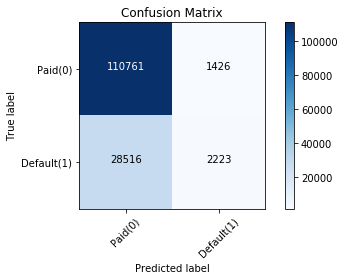

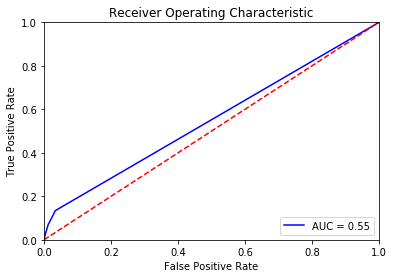

target
goals


predict
goals


In [234]:
score.printScores()
score.plotConfusionMatrix()
score.plotroc()
score.plotResults()


In [235]:
todo = ['l1','l2','rfc','gbc','bagging','adaboost','gaussiannb','decisiontree','kneighbors','sgd']

models = {'l1':LogisticRegression(penalty='l1', random_state=SEED, n_jobs=-2), 
          'l2': LogisticRegression(penalty='l2', random_state=SEED, n_jobs=-2), 
          'rfc': RandomForestClassifier(random_state=SEED, n_jobs=-2), 
          'gbc': GradientBoostingClassifier(random_state=SEED),
          'decisiontree': DecisionTreeClassifier(random_state=SEED),
          'kneighbors': KNeighborsClassifier(n_jobs=-2), 
          'sgd': SGDClassifier(random_state=SEED, n_jobs=-2),
          'bagging': BaggingClassifier(random_state=SEED, n_jobs=-2),
          'adaboost': AdaBoostClassifier(random_state=SEED),
          'gaussiannb': GaussianNB()
          }



Fitting  l1
Scores:

    Auroc=0.609  rocauc=0.609  fbeta=0.395  recall=0.059  precision=0.614  Run Time(M)=0.000

    Best Score=0.000
    Best Params={}
    Goals= Precision of 0.614 beats 0.386,  



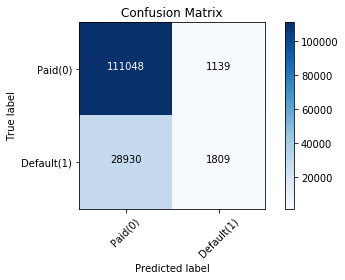

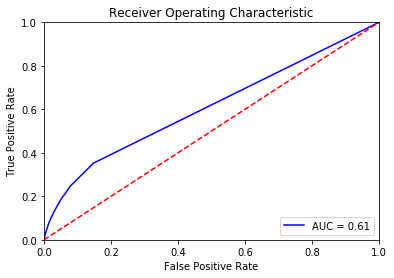

target
goals


predict
goals


Fitting  l2
Scores:

    Auroc=0.609  rocauc=0.609  fbeta=0.395  recall=0.059  precision=0.613  Run Time(M)=0.000

    Best Score=0.000
    Best Params={}
    Goals= Precision of 0.613 beats 0.386,  



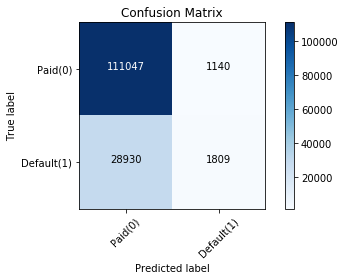

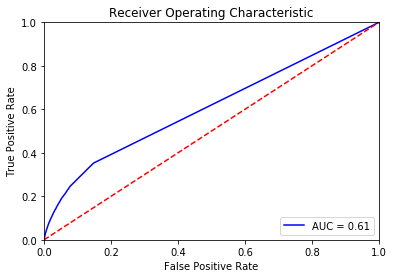

target
goals


predict
goals


Fitting  rfc
Scores:

    Auroc=0.551  rocauc=0.551  fbeta=0.420  recall=0.070  precision=0.611  Run Time(M)=0.000

    Best Score=0.000
    Best Params={}
    Goals= Precision of 0.611 beats 0.386,  



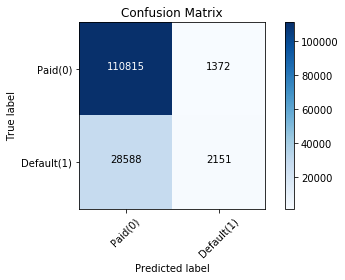

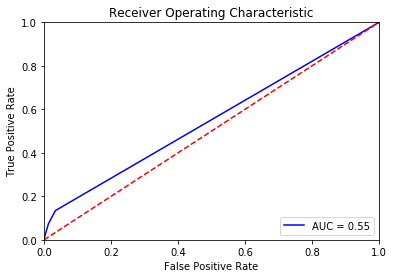

target
goals


predict
goals


Fitting  gbc
Scores:

    Auroc=0.551  rocauc=0.551  fbeta=0.424  recall=0.072  precision=0.610  Run Time(M)=0.000

    Best Score=0.000
    Best Params={}
    Goals= Precision of 0.610 beats 0.386,  



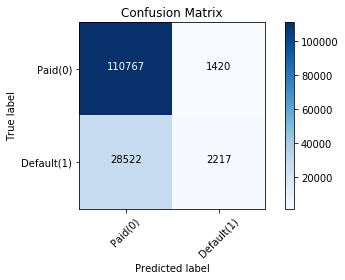

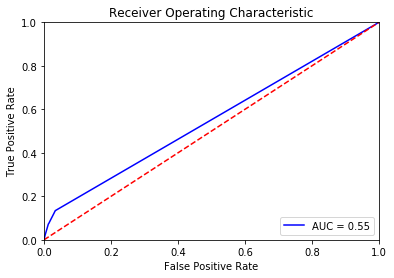

target
goals


predict
goals


Fitting  bagging
Scores:

    Auroc=0.551  rocauc=0.551  fbeta=0.420  recall=0.070  precision=0.611  Run Time(M)=0.000

    Best Score=0.000
    Best Params={}
    Goals= Precision of 0.611 beats 0.386,  



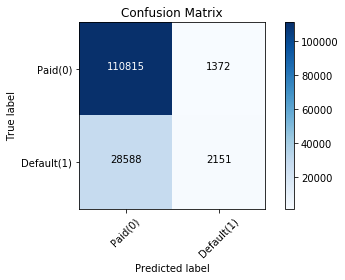

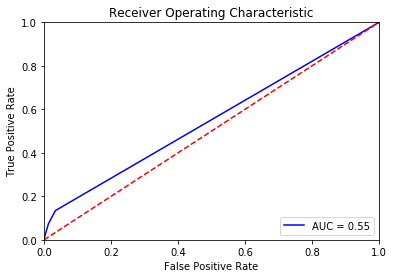

target
goals


predict
goals


Fitting  adaboost
Scores:

    Auroc=0.551  rocauc=0.551  fbeta=0.409  recall=0.066  precision=0.603  Run Time(M)=0.000

    Best Score=0.000
    Best Params={}
    Goals= Precision of 0.603 beats 0.386,  



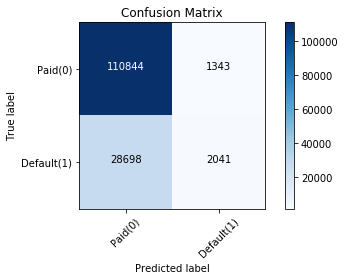

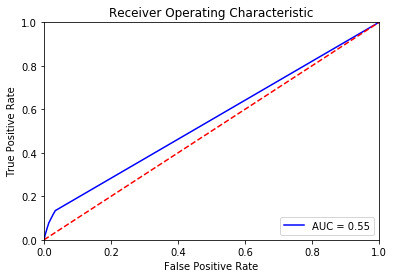

target
goals


predict
goals


Fitting  gaussiannb
Scores:

    Auroc=0.609  rocauc=0.609  fbeta=0.454  recall=0.134  precision=0.534  Run Time(M)=0.000

    Best Score=0.000
    Best Params={}
    Goals= Precision of 0.534 beats 0.386,  fbeta of 0.454 beats 0.440,  



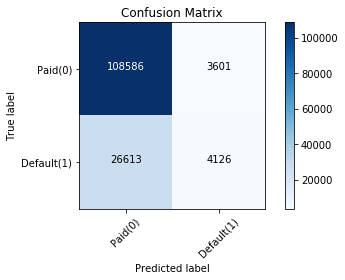

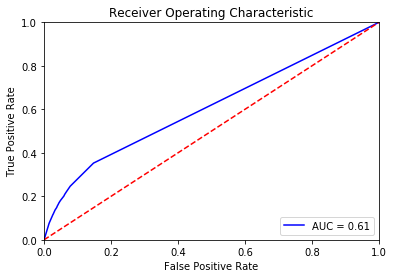

target
goals


predict
goals


Fitting  decisiontree
Scores:

    Auroc=0.551  rocauc=0.551  fbeta=0.424  recall=0.072  precision=0.610  Run Time(M)=0.000

    Best Score=0.000
    Best Params={}
    Goals= Precision of 0.610 beats 0.386,  



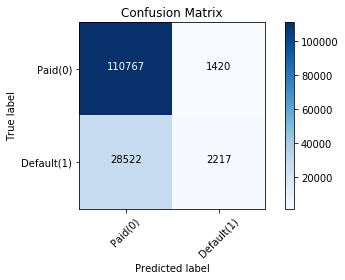

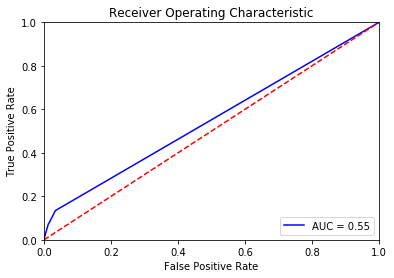

target
goals


predict
goals


Fitting  kneighbors
Scores:

    Auroc=0.464  rocauc=0.464  fbeta=0.328  recall=0.042  precision=0.573  Run Time(M)=0.000

    Best Score=0.000
    Best Params={}
    Goals= Precision of 0.573 beats 0.386,  



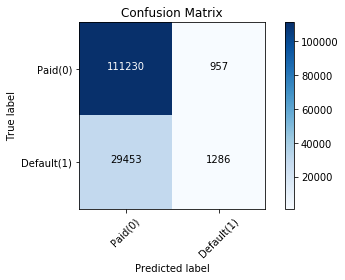

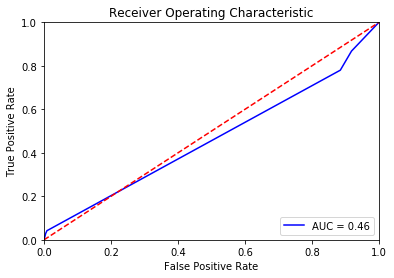

target
goals


predict
goals


Fitting  sgd
Scores:

    Auroc=0.000  rocauc=0.000  fbeta=0.426  recall=0.073  precision=0.611  Run Time(M)=0.000

    Best Score=0.000
    Best Params={}
    Goals= Precision of 0.611 beats 0.386,  



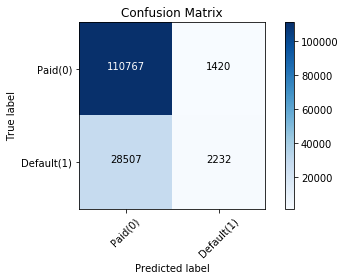

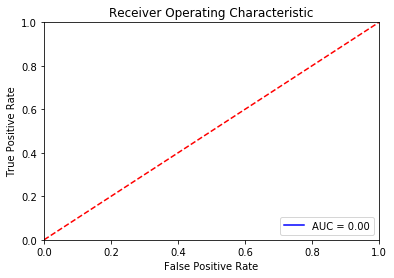

target
goals


predict
goals


In [236]:
for name in todo:
  clf = models[name]
  params = fixHyperparameters(hyperparameters_best[name],useList=False)
  params = {}
  clf.set_params(**params)
  print ('Fitting ', name)
  clf.fit(x_train, y_train)
  score = calcScores(clf,name,params, None, x_test, y_test, runTime=None, goals=None)
  score.printScores() 
  score.plotConfusionMatrix() 
  score.plotroc()
  score.plotResults()


Fitting  gaussiannb
Scores:

    Auroc=0.609  rocauc=0.609  fbeta=0.454  recall=0.134  precision=0.534  Run Time(M)=0.000

    Best Score=0.000
    Best Params={'var_smoothing': 0.01}
    Goals= Precision of 0.534 beats 0.386,  fbeta of 0.454 beats 0.440,  



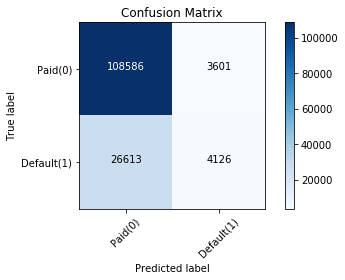

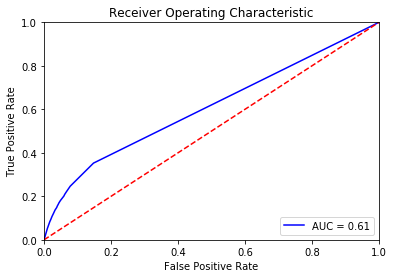

target
goals


predict
goals


In [237]:
# ['l1','l2','rfc','gbc','bagging','adaboost','gaussiannb','decisiontree','kneighbors','sgd']

gaussiannb = {'var_smoothing': 0.010}

newParams = {'gaussiannb':gaussiannb}
 

for name in ['gaussiannb']:
  clf = models[name]
  params = newParams[name]
  clf.set_params(**params)
  print ('Fitting ', name)
  clf.fit(x_train, y_train)
  score = calcScores(clf,name,params, None, x_test, y_test, runTime=None, goals=None)
  score.printScores() 
  score.plotConfusionMatrix() 
  score.plotroc()
  score.plotResults()
